# Домашнее задание

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import seaborn as sns
from matplotlib import pyplot as plt

Представлен датасет центра приюта животных, и вашей задачей будет обучить модель таким образом, чтобы  по определенным признакам была возможность максимально уверенно предсказать метки 'Adoption' и 'Transfer' (столбец “outcome_type”).

Здесь вы вольны делать что угодно. Я хочу видеть от вас:
1. Проверка наличия/обработка пропусков
2. Проверьте взаимосвязи между признаками
3. Попробуйте создать свои признаки
4. Удалите лишние
5. Обратите внимание на текстовые столбцы. Подумайте, что можно извлечь полезного оттуда
6. Использование профайлера вам поможет.
7. Не забывайте, что у вас есть PCA (Метод главных компонент). Он может пригодиться.

Вспомните о всем, что я говорил на предыдущих занятиях. Не все будет пригодится, но в жизни вам никто не будет говорить, что использовать :)

Хорошим классификатором для этой задачи будет "Случайный лес" (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Понимать суть работы "леса" не обязательно на данном этапе, но качество предсказаний будет выше, чем с линейным классификатором. (если желаете, вот гайд https://adataanalyst.com/scikit-learn/linear-classification-method/)

In [2]:
data = pd.read_csv('data/aac_shelter_outcomes.csv')
data.head(2)

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female


In [3]:
data.describe()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
count,78248,78256,78256,78256,78256,78256,78256,78256,54370,35963,78244,78254
unique,46,70855,5,2128,525,5869,64361,64361,14574,19,9,5
top,1 year,A718223,Dog,Domestic Shorthair Mix,Black/White,2014-05-05T00:00:00,2016-04-18T00:00:00,2016-04-18T00:00:00,Bella,Partner,Adoption,Neutered Male
freq,14355,11,44242,23335,8153,112,39,39,344,19660,33112,27784


## Целевое значение

In [4]:
data['outcome_type'].value_counts()

Adoption           33112
Transfer           23499
Return to Owner    14354
Euthanasia          6080
Died                 680
Disposal             307
Rto-Adopt            150
Missing               46
Relocate              16
Name: outcome_type, dtype: int64

In [5]:
# выберем строки с целевыми показателями Adoption и Transfer
data = data.loc[(data['outcome_type'] == 'Adoption') | (data['outcome_type'] == 'Transfer')]
data.head(2)

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female


In [6]:
data['outcome_type'].value_counts()

Adoption    33112
Transfer    23499
Name: outcome_type, dtype: int64

## Обработка пропусков

In [7]:
data.isna().sum()

age_upon_outcome        2
animal_id               0
animal_type             0
breed                   0
color                   0
date_of_birth           0
datetime                0
monthyear               0
name                17951
outcome_subtype     27186
outcome_type            0
sex_upon_outcome        0
dtype: int64

In [8]:
# удалим строки с пустыми значениями age_upon_outcome
data.dropna(subset = ['age_upon_outcome'], inplace=True)

In [9]:
data['outcome_subtype'].value_counts()

Partner    19658
Foster      5558
SCRP        3211
Snr          626
Offsite      367
Barn           3
Name: outcome_subtype, dtype: int64

In [10]:
# заменим нулевые значения name и outcome_subtype на unknown
data.loc[pd.isnull(data['name']), 'name'] = 'unknown'
data.loc[pd.isnull(data['outcome_subtype']), 'outcome_subtype'] = 'unknown'

## Взаимосвязи

In [11]:
data['animal_type'].value_counts()

Dog          29569
Cat          26055
Other          772
Bird           205
Livestock        8
Name: animal_type, dtype: int64

In [12]:
# зависимость между animal_type и breed
data.loc[(data['animal_type'] == 'Cat'), 'breed'].value_counts()

Domestic Shorthair Mix       20809
Domestic Medium Hair Mix      2049
Domestic Longhair Mix         1027
Siamese Mix                    857
Domestic Shorthair             323
                             ...  
Manx                             1
Domestic Medium Hair/Manx        1
Ocicat Mix                       1
Havana Brown Mix                 1
Domestic Shorthair/Manx          1
Name: breed, Length: 75, dtype: int64

In [13]:
# data['age_upon_outcome'].value_counts()

In [14]:
# преобразуем категориальный параметр age_upon_outcome в числовой age_days
data['age_days'] = data['age_upon_outcome'].str.extract(r'([\d]+)').astype(int)

In [15]:
def age_to_value(row):
    if 'year' in str(row['age_upon_outcome']):
        val = row['age_days'] * 365
    elif 'month' in str(row['age_upon_outcome']):
        val = row['age_days'] * 30
    elif 'week' in str(row['age_upon_outcome']):
        val = row['age_days'] * 7
    elif 'day' in str(row['age_upon_outcome']):
        val = row['age_days']
    
    return val

data['age_days'] = data.apply(age_to_value, axis=1)

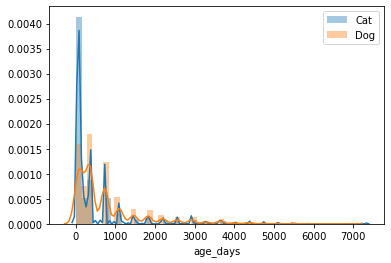

In [16]:
# нет зависимости распределения между категорией animal_type и age_days, но кошек в юном возрасте больше
param1 = data[data['animal_type']=='Cat']['age_days']
param2 = data[data['animal_type']=='Dog']['age_days']

sns.distplot(param1, 50)
sns.distplot(param2, 50)
plt.legend(['Cat', 'Dog'])
plt.show()

## Параметры date_of_birth, datetime, monthyear

In [17]:
# найдем значения где datetime не равен monthyear
len(data.loc[data['datetime'] != data['monthyear']])

0

In [18]:
# подобных значений нет - удалим monthyear
data.drop(['monthyear'], axis=1, inplace=True)

In [19]:
# мы рассчитали возраст животного через age_upon_outcome - date_of_birth больше не нужен
data.drop(['date_of_birth'], axis=1, inplace=True)

In [20]:
# из datetime извлечем год и сезонность
data['date'] = data['datetime'].str.extract(r'([\d-]+)T')
data.drop(['datetime'], axis=1, inplace=True)
data['date'] = pd.to_datetime(data['date'])

In [21]:
# добавляем год
data['year'] = data['date'].dt.year

In [22]:
# добавляем сезон
def quartal(month):
    if month < 4:
        return 1
    if month < 7:
        return 2
    if month < 10:
        return 3
    return 4

data.loc[:, 'quartal'] = data['date'].apply(lambda x: quartal(x.month))

In [23]:
# удаляем вспомогательный параметр date
data.drop(['date'], axis=1, inplace=True)

In [24]:
# удаляем параметр age_upon_outcome
data.drop(['age_upon_outcome'], axis=1, inplace=True)

In [25]:
data.head(2)

,animal_id,animal_type,breed,color,name,outcome_subtype,outcome_type,sex_upon_outcome,age_days,year,quartal
0,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,unknown,Partner,Transfer,Intact Male,14,2014,3
1,A666430,Dog,Beagle Mix,White/Brown,Lucy,Partner,Transfer,Spayed Female,365,2013,4


## Параметр animal_type

In [26]:
data['animal_type'].value_counts()

Dog          29569
Cat          26055
Other          772
Bird           205
Livestock        8
Name: animal_type, dtype: int64

In [27]:
# объединяем Bird и Livestock с other
data.loc[data['animal_type'].isin(['Bird', 'Livestock']), 'animal_type'] = 'Other'

In [28]:
data['animal_type'].value_counts()

Dog      29569
Cat      26055
Other      985
Name: animal_type, dtype: int64

In [29]:
# преобразуем параметр с помощью one hot encoder
ohe_enc = OneHotEncoder()
animal_type_values = ohe_enc.fit_transform(data[['animal_type']]).toarray()
animal_type_columns = ohe_enc.categories_[0]
animal_type_df = pd.DataFrame(animal_type_values, columns = animal_type_columns)
animal_type_df.head(2)

,Cat,Dog,Other
0,1.0,0.0,0.0
1,0.0,1.0,0.0


In [30]:
# соединяем таблицы
data.reset_index(inplace=True)
animal_type_df.index.max(), data.index.max()

(56608, 56608)

In [31]:
data = pd.concat([data, animal_type_df], axis=1)

In [32]:
# удаляем animal_type
data.drop(['animal_type'], axis=1, inplace=True)

In [33]:
data.drop(['index'], axis=1, inplace=True)

In [34]:
data.head(2)

,animal_id,breed,color,name,outcome_subtype,outcome_type,sex_upon_outcome,age_days,year,quartal,Cat,Dog,Other
0,A684346,Domestic Shorthair Mix,Orange Tabby,unknown,Partner,Transfer,Intact Male,14,2014,3,1.0,0.0,0.0
1,A666430,Beagle Mix,White/Brown,Lucy,Partner,Transfer,Spayed Female,365,2013,4,0.0,1.0,0.0


## Параметр breed

In [35]:
# data.loc[(data['Cat'] == 1), 'breed'].value_counts()
data['breed'].value_counts()

Domestic Shorthair Mix                   20809
Pit Bull Mix                              3509
Chihuahua Shorthair Mix                   3399
Labrador Retriever Mix                    3258
Domestic Medium Hair Mix                  2049
                                         ...  
Great Dane/Pointer                           1
Australian Cattle Dog/Black Mouth Cur        1
Dachshund Wirehair/West Highland             1
American Pit Bull Terrier/Pit Bull           1
English Bulldog/Beagle                       1
Name: breed, Length: 1802, dtype: int64

In [36]:
# удалим значения с малым количеством повторений
small_index = list(data['breed'].value_counts()
                   [data['breed'].value_counts() < 3].index)

In [37]:
len(data[data['breed'].isin(small_index)])

1355

In [38]:
data = data[~data['breed'].isin(small_index)]

In [39]:
# выделим из параметра признак is_mixed
data.loc[(data['Dog'] == 1), 'breed'].value_counts()

Pit Bull Mix                      3509
Chihuahua Shorthair Mix           3399
Labrador Retriever Mix            3258
German Shepherd Mix               1265
Australian Cattle Dog Mix          788
                                  ... 
Basset Hound/Pointer                 3
Whippet/Dachshund                    3
Great Pyrenees/Anatol Shepherd       3
Golden Retriever/Collie Rough        3
Bernese Mountain Dog                 3
Name: breed, Length: 642, dtype: int64

In [40]:
# 1 - если содержит mix; 0 - если нет
data['is_mixed'] = data.apply(lambda x: 1 if 'Mix' in x['breed'] else 0, axis=1)

In [41]:
data.head(2)

,animal_id,breed,color,name,outcome_subtype,outcome_type,sex_upon_outcome,age_days,year,quartal,Cat,Dog,Other,is_mixed
0,A684346,Domestic Shorthair Mix,Orange Tabby,unknown,Partner,Transfer,Intact Male,14,2014,3,1.0,0.0,0.0,1
1,A666430,Beagle Mix,White/Brown,Lucy,Partner,Transfer,Spayed Female,365,2013,4,0.0,1.0,0.0,1


## Параметр color

In [42]:
data['color'].value_counts()

Black/White            5977
Black                  5090
Brown Tabby            3966
Brown Tabby/White      2079
Orange Tabby           1913
                       ... 
Red Tick/Brown            1
Blue/Yellow Brindle       1
Black Smoke/Black         1
Gray/Red                  1
Blue Tick/Tricolor        1
Name: color, Length: 460, dtype: int64

In [43]:
# удалим значения с малым количеством повторений
small_index = list(data['color'].value_counts()
                   [data['color'].value_counts() < 15].index)

In [44]:
len(data[data['color'].isin(small_index)])

1029

In [45]:
data = data[~data['color'].isin(small_index)]

In [46]:
data.head(2)

,animal_id,breed,color,name,outcome_subtype,outcome_type,sex_upon_outcome,age_days,year,quartal,Cat,Dog,Other,is_mixed
0,A684346,Domestic Shorthair Mix,Orange Tabby,unknown,Partner,Transfer,Intact Male,14,2014,3,1.0,0.0,0.0,1
1,A666430,Beagle Mix,White/Brown,Lucy,Partner,Transfer,Spayed Female,365,2013,4,0.0,1.0,0.0,1


## Параметр sex_upon_outcome

In [47]:
data['sex_upon_outcome'].value_counts()

Neutered Male    19756
Spayed Female    19058
Intact Female     6677
Intact Male       6094
Unknown           2640
Name: sex_upon_outcome, dtype: int64

In [50]:
# добавим новые признаки is_neutered, is_spayed, is_intact, female, male
data.loc[:, 'is_neutered'] = data.apply(lambda x: 1 if 'Neutered' in x['sex_upon_outcome'] else 0, axis=1)
data.loc[:, 'is_spayed'] = data.apply(lambda x: 1 if 'Spayed' in x['sex_upon_outcome'] else 0, axis=1)
data.loc[:, 'is_intact'] = data.apply(lambda x: 1 if 'Intact' in x['sex_upon_outcome'] else 0, axis=1)
data.loc[:, 'female'] = data.apply(lambda x: 1 if 'Female' in x['sex_upon_outcome'] else 0, axis=1)
data.loc[:, 'male'] = data.apply(lambda x: 1 if 'Male' in x['sex_upon_outcome'] else 0, axis=1)

In [51]:
# удаляем sex_upon_outcome
data.drop(['sex_upon_outcome'], axis=1, inplace=True)

In [52]:
data.head(2)

,animal_id,breed,color,name,outcome_subtype,outcome_type,age_days,year,quartal,Cat,Dog,Other,is_mixed,is_neutered,is_spayed,is_intact,female,male
0,A684346,Domestic Shorthair Mix,Orange Tabby,unknown,Partner,Transfer,14,2014,3,1.0,0.0,0.0,1,0,0,1,0,1
1,A666430,Beagle Mix,White/Brown,Lucy,Partner,Transfer,365,2013,4,0.0,1.0,0.0,1,0,1,0,1,0


## Параметр outcome_subtype

In [53]:
data['outcome_subtype'].value_counts()

unknown    25804
Partner    18872
Foster      5401
SCRP        3185
Snr          612
Offsite      348
Barn           3
Name: outcome_subtype, dtype: int64

In [54]:
# объединяем Barn с unknown
data.loc[data['outcome_subtype'] == 'Barn', 'outcome_subtype'] = 'unknown'

In [55]:
data['outcome_subtype'].value_counts()

unknown    25807
Partner    18872
Foster      5401
SCRP        3185
Snr          612
Offsite      348
Name: outcome_subtype, dtype: int64

In [56]:
# преобразуем параметр с помощью one hot encoder
ohe_enc = OneHotEncoder()
outcome_subtype_values = ohe_enc.fit_transform(data[['outcome_subtype']]).toarray()
outcome_subtype_columns = ohe_enc.categories_[0]
outcome_subtype_df = pd.DataFrame(outcome_subtype_values, columns = outcome_subtype_columns)
outcome_subtype_df.head(2)

,Foster,Offsite,Partner,SCRP,Snr,unknown
0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0


In [57]:
# соединяем таблицы
data.reset_index(inplace=True)
outcome_subtype_df.index.max(), data.index.max()

(54224, 54224)

In [58]:
data = pd.concat([data, outcome_subtype_df], axis=1)

In [59]:
# удаляем animal_type
data.drop(['outcome_subtype'], axis=1, inplace=True)

In [60]:
data.drop(['index'], axis=1, inplace=True)

In [61]:
data.head(2)

,animal_id,breed,color,name,outcome_type,age_days,year,quartal,Cat,Dog,...,is_spayed,is_intact,female,male,Foster,Offsite,Partner,SCRP,Snr,unknown
0,A684346,Domestic Shorthair Mix,Orange Tabby,unknown,Transfer,14,2014,3,1.0,0.0,...,0,1,0,1,0.0,0.0,1.0,0.0,0.0,0.0
1,A666430,Beagle Mix,White/Brown,Lucy,Transfer,365,2013,4,0.0,1.0,...,1,0,1,0,0.0,0.0,1.0,0.0,0.0,0.0


## Параметр animal_id

In [62]:
# удаляем animal_id как служебный
data.drop(['animal_id'], axis=1, inplace=True)

In [63]:
data.head(2)

,breed,color,name,outcome_type,age_days,year,quartal,Cat,Dog,Other,...,is_spayed,is_intact,female,male,Foster,Offsite,Partner,SCRP,Snr,unknown
0,Domestic Shorthair Mix,Orange Tabby,unknown,Transfer,14,2014,3,1.0,0.0,0.0,...,0,1,0,1,0.0,0.0,1.0,0.0,0.0,0.0
1,Beagle Mix,White/Brown,Lucy,Transfer,365,2013,4,0.0,1.0,0.0,...,1,0,1,0,0.0,0.0,1.0,0.0,0.0,0.0


## Обучение модели

In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54225 entries, 0 to 54224
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   breed         54225 non-null  object 
 1   color         54225 non-null  object 
 2   name          54225 non-null  object 
 3   outcome_type  54225 non-null  object 
 4   age_days      54225 non-null  int64  
 5   year          54225 non-null  int64  
 6   quartal       54225 non-null  int64  
 7   Cat           54225 non-null  float64
 8   Dog           54225 non-null  float64
 9   Other         54225 non-null  float64
 10  is_mixed      54225 non-null  int64  
 11  is_neutered   54225 non-null  int64  
 12  is_spayed     54225 non-null  int64  
 13  is_intact     54225 non-null  int64  
 14  female        54225 non-null  int64  
 15  male          54225 non-null  int64  
 16  Foster        54225 non-null  float64
 17  Offsite       54225 non-null  float64
 18  Partner       54225 non-nu

In [89]:
data.loc[:, 'outcome_type_int'] = data.apply(lambda x: 1 if 'Adoption' in x['outcome_type'] else 0, axis=1)

In [115]:
# входные данные
X = data.drop(['breed', 'color', 'name', 'outcome_type', 'outcome_type_int'], axis=1)
# вектор целевых значений
y = data['outcome_type_int']

In [116]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

Train MAE: 2.634560160181258e-05
Test MAE: 0.0
----------------------
              precision    recall  f1-score   support

           0       0.42      0.42      0.42      6781
           1       0.59      0.58      0.58      9487

    accuracy                           0.52     16268
   macro avg       0.50      0.50      0.50     16268
weighted avg       0.52      0.52      0.52     16268



No handles with labels found to put in legend.


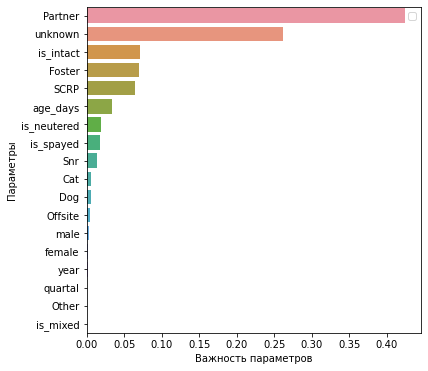

In [117]:
def teach_model(X, y):
    # делим выборку на test и train
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    # обучаем модель
    model = RandomForestClassifier(n_estimators=100)
    model.fit(X_train, y_train)

    # обучаемое предсказание
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # сравнение предсказания и реального результата
    print('Train MAE: {}'.format(mean_absolute_error(train_predict, y_train)))
    print('Test MAE: {}'.format(mean_absolute_error(test_predict, y_test)))
    print('----------------------')
    print(classification_report(y_test, model_pred))
    model.score(X_test, y_test)
    
    # список параметров
    headers = list(X_train.columns.values)
    feature_imp = pd.Series(model.feature_importances_, index=headers).sort_values(ascending=False)
    f, ax = plt.subplots(figsize=(6, 6))
    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.xlabel('Важность параметров')
    plt.ylabel('Параметры')
    plt.legend()
    plt.show()
        
teach_model(X, y)

Train MAE: 0.13773480517427616
Test MAE: 0.17193262847307597
----------------------
              precision    recall  f1-score   support

           0       0.42      0.42      0.42      6849
           1       0.58      0.58      0.58      9419

    accuracy                           0.51     16268
   macro avg       0.50      0.50      0.50     16268
weighted avg       0.51      0.51      0.51     16268



No handles with labels found to put in legend.


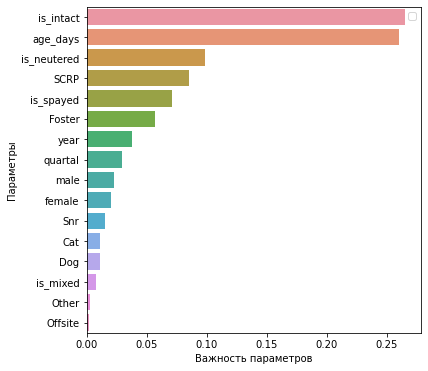

In [118]:
# входные данные - удаляем Partner и unknown
X = data.drop(['breed', 'color', 'name', 'outcome_type', 'outcome_type_int', 'Partner', 'unknown'], axis=1)
# вектор целевых значений
y = data['outcome_type_int']

teach_model(X, y)

Train MAE: 0.1608925889822694
Test MAE: 0.1598229653307106
----------------------
              precision    recall  f1-score   support

           0       0.42      0.42      0.42      6842
           1       0.58      0.58      0.58      9426

    accuracy                           0.51     16268
   macro avg       0.50      0.50      0.50     16268
weighted avg       0.51      0.51      0.51     16268



No handles with labels found to put in legend.


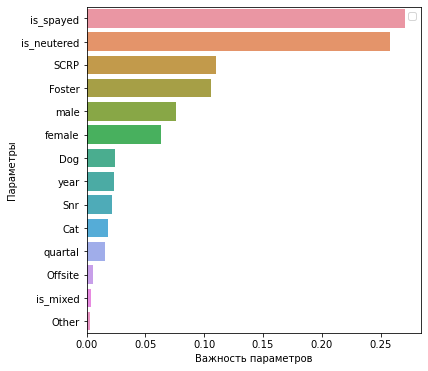

In [119]:
# входные данные - удаляем Partner и unknown
X = data.drop(['breed', 'color', 'name', 'outcome_type', 
               'outcome_type_int', 'Partner', 'unknown', 'is_intact', 'age_days'], axis=1)
# вектор целевых значений
y = data['outcome_type_int']

teach_model(X, y)